In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,\
      MaxPool2D, Conv2D, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ModelCheckpoint 

In [2]:
IMG_SIZE=28
batch_size=200
epochs=30

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train = x_train.reshape(x_train.shape[0],IMG_SIZE,IMG_SIZE,1).astype('float32')
x_test = x_test.reshape(x_test.shape[0],IMG_SIZE,IMG_SIZE,1).astype('float32')
x_train /= 255
x_test /= 255
y_train = np_utils.to_categorical(y_train) 
y_test = np_utils.to_categorical(y_test)

In [5]:
classifier = Sequential()
classifier.add(Conv2D(32, (3,3), input_shape=(IMG_SIZE,IMG_SIZE,1)))
# classifier.add(BatchNormalization(axis=-1))  
classifier.add(Activation('relu'))

classifier.add(Conv2D(32, (3,3)))
# classifier.add(BatchNormalization(axis=-1))
classifier.add(Activation('relu'))

classifier.add(MaxPool2D(pool_size=(2,2)))
# classifier.add(BatchNormalization(axis=-1))

classifier.add(Conv2D(64, (3,3)))
# classifier.add(BatchNormalization(axis=-1))
classifier.add(Activation('relu'))

classifier.add(Conv2D(64, (3,3)))
classifier.add(Activation('relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))

classifier.add(Flatten())
# classifier.add(BatchNormalization())

classifier.add(Dense(512))
# classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Dropout(0.2))
classifier.add(Dense(10))
classifier.add(Activation('softmax'))

In [6]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
classifier.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [8]:
train_gen = ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.1,
                               shear_range=0.3,
                               height_shift_range=0.1,
                               zoom_range=0.1)
test_gen = ImageDataGenerator()

In [9]:
training_set = train_gen.flow(x_train,y_train,batch_size=batch_size)
test_set = train_gen.flow(x_test,y_test,batch_size=batch_size)

In [10]:
# model_save_path = 'straight_bs200e30_tf25.h5'
# checkpoint_callback = ModelCheckpoint(model_save_path,
#                                       monitor='val_accuracy',
#                                       save_best_only=True,
#                                       verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # better than val_acc
                                               patience=4,  # better than 3
                                               mode='auto', # default
                                               verbose=1)

In [11]:
history = classifier.fit(training_set,
                         steps_per_epoch=len(x_train)//batch_size, # 300
                         validation_data=test_set,
                         validation_steps=len(x_test)//batch_size, # 50
                         epochs=epochs,
                        #  callbacks=[checkpoint_callback])
                         callbacks=[es_callback])

Epoch 1/30
300/300 [==============================] - 20s 57ms/step - loss: 0.3426 - accuracy: 0.8909 - val_loss: 0.0862 - val_accuracy: 0.9740
Epoch 2/30
300/300 [==============================] - 17s 57ms/step - loss: 0.0910 - accuracy: 0.9728 - val_loss: 0.0806 - val_accuracy: 0.9746
Epoch 3/30
300/300 [==============================] - 17s 58ms/step - loss: 0.0674 - accuracy: 0.9792 - val_loss: 0.0494 - val_accuracy: 0.9852
Epoch 4/30
300/300 [==============================] - 18s 58ms/step - loss: 0.0540 - accuracy: 0.9834 - val_loss: 0.0358 - val_accuracy: 0.9881
Epoch 5/30
300/300 [==============================] - 17s 58ms/step - loss: 0.0458 - accuracy: 0.9858 - val_loss: 0.0382 - val_accuracy: 0.9875
Epoch 6/30
300/300 [==============================] - 17s 57ms/step - loss: 0.0401 - accuracy: 0.9880 - val_loss: 0.0325 - val_accuracy: 0.9896
Epoch 7/30
300/300 [==============================] - 17s 57ms/step - loss: 0.0382 - accuracy: 0.9878 - val_loss: 0.0313 - val_accuracy:

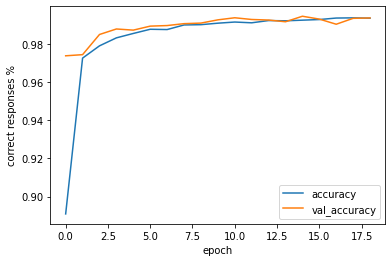

In [12]:
plt.plot(history.history['accuracy'],
         label='accuracy')
plt.plot(history.history['val_accuracy'],
         label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('correct responses %')
plt.legend()
plt.show()

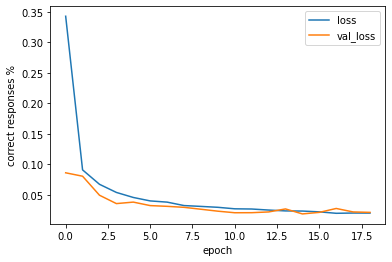

In [13]:
plt.plot(history.history['loss'],
         label='loss')
plt.plot(history.history['val_loss'],
         label='val_loss')
plt.xlabel('epoch')
plt.ylabel('correct responses %')
plt.legend()
plt.show()

In [18]:
classifier.save('es4.h5')